In [235]:
import datetime
import os
import json
import random
import re
import regex
import pandas as pd
import matplotlib.pyplot as plt

In [50]:
with open('/home/ws/ys8950/dev/data/paperswithcode/data/papers-with-abstracts-extended.json') as f:
    df_paper_abstracts_extended = pd.DataFrame(json.load(f))
with open('/home/ws/ys8950/dev/data/paperswithcode/data/methods.json') as f:
    df_methods = pd.DataFrame(json.load(f))
with open('/home/ws/ys8950/dev/data/paperswithcode/data/datasets.json') as f:
    df_datasets = pd.DataFrame(json.load(f))

In [66]:
print('- - - - - paper_abstracts columns - - - - - -')
print(df_paper_abstracts_extended.columns.to_list())
print('- - - - - methods dicts - - - - - -')
print(list(df_paper_abstracts_extended[
    df_paper_abstracts_extended['methods'].apply(lambda x: len(x)) > 0
].iloc[0].methods[0].keys()))
print('- - - - - dataset dicts - - - - - -')
print(list(df_paper_abstracts_extended[
    df_paper_abstracts_extended['datasets'].apply(lambda x: len(x)) > 0
].iloc[0].datasets[0].keys()))
print('- - - - - method columns - - - - - -')
print(df_methods.columns.to_list())
print('- - - - - dataset columns - - - - - -')
print(df_datasets.columns.to_list())

- - - - - paper_abstracts columns - - - - - -
['paper_url', 'arxiv_id', 'title', 'abstract', 'url_abs', 'url_pdf', 'proceeding', 'authors', 'tasks', 'date', 'methods', 'datasets']
- - - - - methods dicts - - - - - -
['name', 'full_name', 'description', 'introduced_year', 'source_url', 'source_title', 'code_snippet_url', 'main_collection']
- - - - - dataset dicts - - - - - -
['url', 'name', 'full_name', 'homepage', 'description', 'paper', 'introduced_date', 'warning', 'modalities', 'tasks', 'languages', 'variants', 'num_papers', 'data_loaders']
- - - - - method columns - - - - - -
['url', 'name', 'full_name', 'description', 'paper', 'introduced_year', 'source_url', 'source_title', 'code_snippet_url', 'collections']
- - - - - dataset columns - - - - - -
['url', 'name', 'full_name', 'homepage', 'description', 'paper', 'introduced_date', 'warning', 'modalities', 'tasks', 'languages', 'variants', 'num_papers', 'data_loaders']


### Create easily accessible "paper usage" records for data sets and methods

In [167]:
def paper_df_or_row_to_dict(paper_df):
    """ Create a slightly stripped down dict version of a paper dataframe row
    
        (strips datasets and methods column)
    """
    
    keep_columns = [
        'paper_url', 'arxiv_id', 'title', 'abstract', 'url_abs', # all but methods and data sets
        'url_pdf', 'proceeding', 'authors', 'tasks', 'date'
    ]
    if type(paper_df) == pd.DataFrame:
        if paper_df.shape[0] == 0:
            return None
        assert (paper_df.shape[0] == 1), 'paper URL not unique'
        paper_dict = paper_df[
            keep_columns
        ].iloc[0].to_dict()
    elif type(paper_df) == pd.Series:
        paper_dict = dict()
        for col in keep_columns:
            paper_dict[col] = paper_df[col]
    else:
        raise
     
    return paper_dict


datasets = dict()
methods = dict()
for idx, ppr in df_paper_abstracts_extended.iterrows():
    current_paper_dict = paper_df_or_row_to_dict(ppr)
    for m in ppr.methods:
        if m['full_name'] not in methods:
            # initialize method dict
            meth_dict = m.copy()
            # add extra data if retrievable
            extra_data = df_methods[df_methods.full_name == m['full_name']]
            if extra_data.shape[0] == 0:  # method name not in methods dataframe
                intro_paper_dict = None
            else:
                # assert (extra_data.shape[0] == 1), 'method name not unique'
                # ↑ violated by e.g. Differentiable Neural Architecture Search
                extra_dict = extra_data.iloc[0].to_dict()  # just take the first
                meth_dict.update(extra_dict)
                if meth_dict['paper'] is not None:  # 'paper' only in extra data, therefore in else part
                    intro_paper = df_paper_abstracts_extended[
                        df_paper_abstracts_extended.paper_url == 'https://paperswithcode.com/paper/' + meth_dict['paper']
                    ]
                    intro_paper_dict = paper_df_or_row_to_dict(intro_paper)
            methods[m['full_name']] = {
                'pwc_data': meth_dict,
                'intro_paper': intro_paper_dict,
                'using_papers': []
            }
        # add info on current paper
        methods[m['full_name']]['using_papers'].append(current_paper_dict)
    for d in ppr.datasets:
        if d['url'] not in datasets:
            # initialize dataset dict
            data_dict = d.copy()
            datasets[d['url']] = {
                'pwc_data': data_dict,
                'using_papers': []
            }
        # add info on current paper
        datasets[d['url']]['using_papers'].append(current_paper_dict)

In [172]:
# for name, method in methods.items():
#     print(name)
#     for ppr in method['using_papers']:
#         print(ppr['date'])
# for url, dataset in datasets.items():
#     print(dataset['pwc_data']['name'])
#     for ppr in dataset['using_papers']:
#         print(ppr['date'])

In [173]:
# with open('/home/ws/ys8950/dev/data/paperswithcode/data/methods_with_using_papers.json', 'w') as f:
#     json.dump(methods, f)
# with open('/home/ws/ys8950/dev/data/paperswithcode/data/datasets_with_using_papers.json', 'w') as f:
#     json.dump(datasets, f)

### Starting from papers with joint data set & method use, create usage records

In [164]:
df_methdata_papers = df_paper_abstracts_extended[
    (df_paper_abstracts_extended['methods'].apply(lambda x: len(x)) > 0)
    &
    (df_paper_abstracts_extended['datasets'].apply(lambda x: len(x)) > 0)
]

In [178]:
combo_use_pairs = set()
for idx, row in df_methdata_papers.iterrows():
    ds = [d['url'] for d in row['datasets']]
    ms = [m['full_name'] for m in row['methods']]
    for d in ds:
        for m in ms:
            combo_use_pairs.add(f'{d}\t{m}')
combo_use_pairs = [p.split('\t') for p in combo_use_pairs]

In [220]:
def add_record_entry_data(rec_dict, ppr_type, ppr_dict, uses_meth=0, uses_data=0):
    if 'arxiv_id' in ppr_dict and ppr_dict['arxiv_id'] is not None:
        record_key = ppr_dict['arxiv_id']
    else:
        record_key = ppr_dict['paper_url']
    if record_key not in rec_dict:
        rec_dict[record_key] = {
            'type': ppr_type,  # intro papers always come first, so this won't be overwritten
            'date': ppr_dict['date'],
            'arxiv_id': ppr_dict['arxiv_id'],
            'uses_meth': uses_meth,
            'uses_data': uses_data
        }
    else:
        if uses_meth == 1:
            rec_dict[record_key]['uses_meth'] = 1
        elif uses_data == 1:
            rec_dict[record_key]['uses_data'] = 1
    # return not necessary b/c dicts are immutable


pair_records = dict()
for pair in combo_use_pairs:
    dataset_url = pair[0]
    method_full_name = pair[1]
    dataset_record = datasets[dataset_url]
    method_record = methods[method_full_name]
    pair_key = f'{dataset_record["pwc_data"]["name"]} + {method_record["pwc_data"]["full_name"]}'
    record_dict = dict()
    if method_record['intro_paper'] is not None:
        add_record_entry_data(
            record_dict,
            'intro',
            method_record['intro_paper'],
            uses_meth=1, 
            uses_data=0
        )
    for using_paper in method_record['using_papers']:
        add_record_entry_data(
            record_dict,
            'use',
            using_paper,
            uses_meth=1, 
            uses_data=0
        )
    for using_paper in dataset_record['using_papers']:
        add_record_entry_data(
            record_dict,
            'use',
            using_paper,
            uses_meth=0, 
            uses_data=1
        )
    pair_records[pair_key] = record_dict.copy()

In [228]:
# with open('/home/ws/ys8950/dev/software_campus/pwc-X-unarXive/combi_use_records.json', 'w') as f:
#     json.dump(pair_records, f)

### Visualize / Analyze

In [242]:
random_pair = random.choice(list(pair_records.keys()))
print(random_pair)
pair_records[random_pair]

# TODO:
# - write visualization routine
#   - find nice example and manually play through
# - additionally link w/ unarXive citations
#   - extend visualization
# - consider adding full text contexts

ChestX-ray8 + Interpretability


{'1804.03201': {'type': 'use',
  'date': '2018-04-09',
  'arxiv_id': '1804.03201',
  'uses_meth': 1,
  'uses_data': 0},
 '1806.04820': {'type': 'use',
  'date': '2018-06-13',
  'arxiv_id': '1806.04820',
  'uses_meth': 1,
  'uses_data': 0},
 '1710.08464': {'type': 'use',
  'date': '2017-10-23',
  'arxiv_id': '1710.08464',
  'uses_meth': 1,
  'uses_data': 0},
 '1806.04555': {'type': 'use',
  'date': '2018-06-12',
  'arxiv_id': '1806.04555',
  'uses_meth': 1,
  'uses_data': 0},
 '1806.04310': {'type': 'use',
  'date': '2018-06-12',
  'arxiv_id': '1806.04310',
  'uses_meth': 1,
  'uses_data': 0},
 '1806.02199': {'type': 'use',
  'date': '2018-06-06',
  'arxiv_id': '1806.02199',
  'uses_meth': 1,
  'uses_data': 0},
 '1806.01830': {'type': 'use',
  'date': '2018-06-05',
  'arxiv_id': '1806.01830',
  'uses_meth': 1,
  'uses_data': 0},
 '1803.07658': {'type': 'use',
  'date': '2018-03-20',
  'arxiv_id': '1803.07658',
  'uses_meth': 1,
  'uses_data': 0},
 '1806.00712': {'type': 'use',
  'date':

In [964]:
def simple_timeline(record_dict, title):
    def usage_profile_to_category(uses_meth, uses_data):
        if uses_meth and not uses_data:
            return 'meth'
        elif not uses_meth and uses_data:
            return 'data'
        elif uses_meth and uses_data:
            return 'COMBI'
        else:
            return 'none'
    color_mapping = {'intro': 'r', 'use': 'b'}
    x = []
    y = []
    c = []
    labels = []
    for arxiv_id, usage in record_dict.items():
        x.append(
            datetime.datetime.strptime(usage['date'], '%Y-%m-%d')
        )
        y.append(
            usage_profile_to_category(usage['uses_meth'], usage['uses_data'])
        )
        c.append(color_mapping[usage['type']])
        labels.append(arxiv_id)
    
    plt.figure(figsize=(14,4))
    plt.title(title)
    # plt.ylim((-1,len(series)))
    # plt.xlim((-1000, dataset[-1][0]+1000))
    # plt.yticks(range(len(series)), series)
    plt.scatter(x, y, color=c, alpha=0.85) # , s=10
    return plt

In [1040]:
def combi_metrics(record_dict, echo=True):
    def papers_per_month(date_list):
        if len(date_list) == 0:
            return 0
        months = (
            max(date_list) - min(date_list)
        ).days / 30.437
        return len(date_list) / max(months, 1)
        
    combi_dates = []
    data_dates = []
    meth_dates = []
    for arxiv_id, usage in record_dict.items():
        if usage['uses_meth'] == 1 and usage['uses_data'] == 1:
            combi_dates.append(
                datetime.datetime.strptime(usage['date'], '%Y-%m-%d')
            )
        elif usage['uses_data'] == 1:
            data_dates.append(
                datetime.datetime.strptime(usage['date'], '%Y-%m-%d')
            )
        elif usage['uses_meth'] == 1:
            meth_dates.append(
                datetime.datetime.strptime(usage['date'], '%Y-%m-%d')
            )
    if len(data_dates) == 0:  # workaround for metrics
        data_dates.append(
            min(combi_dates)
        )
    if len(meth_dates) == 0:  # workaround for metrics
        meth_dates.append(
            min(combi_dates)
        )
    time_data_to_combi = min(combi_dates) - min(data_dates)
    time_meth_to_combi = min(combi_dates) - min(meth_dates)
    time_delta_data_meth = abs(min(data_dates) - min(meth_dates))
    pre_combi_data_papers = len([
            date for date in data_dates
            if date < min(combi_dates)
    ])
    pre_combi_meth_papers = len([
            date for date in meth_dates
            if date < min(combi_dates)
    ])
    combi_paper_num = len(combi_dates)
    combi_time_span = (max(combi_dates) - min(combi_dates)).days
    combi_ppm_rate = papers_per_month(combi_dates)
    post_combi_data_ppm_rate = papers_per_month([
            date for date in data_dates
            if date > min(combi_dates)
    ])
    post_combi_meth_ppm_rate = papers_per_month([
            date for date in meth_dates
            if date > min(combi_dates)
    ])
    if echo:
        print((
            f'- - - stats - - -\n'
            f'[pre combi]\n'
            f'd→c:\t\t{time_data_to_combi.days} days, {pre_combi_data_papers} papers\n'
            f'm→c:\t\t{time_meth_to_combi.days} days, {pre_combi_meth_papers} papers\n'
            f'|m-d|:\t\t{time_delta_data_meth.days} days\n'
            f'[post combi]\n'
            f'combi #pprs:\t{combi_paper_num}\n'
            f'combi time:\t{combi_time_span}\n'
            f'combi ppr/M:\t{combi_ppm_rate}\n'
            f'data ppr/M:\t{post_combi_data_ppm_rate}\n'
            f'meth ppr/M:\t{post_combi_meth_ppm_rate}\n'
        ))
    return {
        'time_data_to_combi.days':  time_data_to_combi.days,
        'pre_combi_data_papers':    pre_combi_data_papers,
        'time_meth_to_combi.days':  time_meth_to_combi.days,
        'pre_combi_meth_papers':    pre_combi_meth_papers,
        'time_delta_data_meth.days':time_delta_data_meth.days,
        'combi_paper_num':          combi_paper_num,
        'combi_time_span':          combi_time_span,
        'combi_ppm_rate':           combi_ppm_rate,
        'post_combi_data_ppm_rate': post_combi_data_ppm_rate,
        'post_combi_meth_ppm_rate': post_combi_meth_ppm_rate
    }

metrics = combi_metrics(pair_records[random_pair])

- - - stats - - -
[pre combi]
d→c:		1602 days, 1050 papers
m→c:		740 days, 20 papers
|m-d|:		862 days
[post combi]
combi #pprs:	13
combi time:	1147
combi ppr/M:	0.3449703574542284
data ppr/M:	97.62562065972223
meth ppr/M:	11.898582897033158



- - - stats - - -
[pre combi]
d→c:		2106 days, 78 papers
m→c:		354 days, 46 papers
|m-d|:		1752 days
[post combi]
combi #pprs:	14
combi time:	1245
combi ppr/M:	0.342263453815261
data ppr/M:	34.31124025457438
meth ppr/M:	63.144696825396835



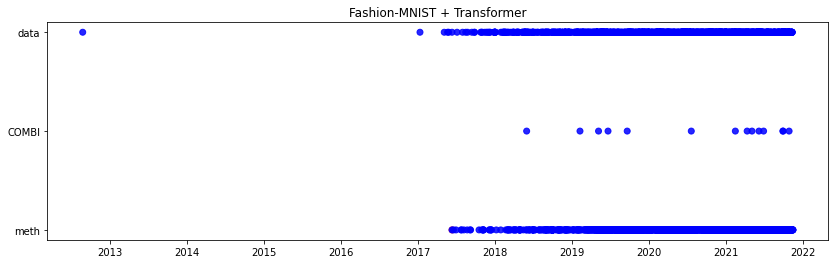

In [1088]:
while True:
    random_pair = random.choice(list(pair_records.keys()))
    data_name, meth_name = random_pair.split(' + ')
    if meth_name in [
        'Softmax',
        'Dropout',
        'Residual Connection',
        'Average Pooling',
        'Weight Decay',
        'Convolution',
        'Max Pooling',
        'Adam',
        'Layer Normalization',
        'Batch Normalization',
        '1x1 Convolution',
        'Tanh Activation',
        'Sigmoid Activation',
        'Leaky ReLU',
        'Heatmap',
        'Dense Connections',
        'Softmax',
        'Multi-Head Attention',  # ---
        'Scaled Dot-Product Attention',
        'Gaussian Error Linear Units',
        'Rectified Linear Units',
        'Attention Dropout',
        'Byte Pair Encoding',
        'Linear Warmup With Linear Decay',
        'Label Smoothing',
        'Position-Wise Feed-Forward Layer',
        'Absolute Position Encodings',
        'Global Average Pooling'
    ]:
        continue
    combi_use_count = 0
    for _, usage in pair_records[random_pair].items():
        if usage['uses_meth'] + usage['uses_data'] == 2:
            combi_use_count += 1
    if combi_use_count > 10:
        break
# pprint.pprint(pair_records[random_pair])
plt = simple_timeline(pair_records[random_pair], random_pair)
combi_metrics(pair_records[random_pair])
plt.show()

# more stuff/longer time before combi       -> better
# data/meth start delta                     -> ?
# combi ppr/M                               -> higher=better
# combi ppr/M relative to data/meth ppr/M
#     >1 = mostly used in combination
#     <1 = also used for other stuff
#    <<1 = generally very common method
#                                           -> ?
# rate of frequency also mby important?
# (e.g. in case of sudden boom mby not
#  so interesting)

# extra considerations
# -> more interesting if combi-method not also frequently used for other *similar* datasets
# -> derivatie methods later also used for combi

In [892]:
count = 0
meth_counts = dict()
data_counts = dict()
for pair_key, record_dict in pair_records.items():
    data_name, meth_name = pair_key.split(' + ', maxsplit = 1)
    if meth_name in [
        'Softmax',
        'Dropout',
        'Residual Connection',
        'Average Pooling',
        'Weight Decay',
        'Convolution',
        'Max Pooling',
        'Adam',
        'Layer Normalization',
        'Batch Normalization',
        '1x1 Convolution',
        'Tanh Activation',
        'Sigmoid Activation',
        'Leaky ReLU',
        'Heatmap',
        'Dense Connections',
        'Softmax',
        'Multi-Head Attention',  # ---
        'Scaled Dot-Product Attention',
        'Gaussian Error Linear Units',
        'Rectified Linear Units',
        'Attention Dropout',
        'Byte Pair Encoding',
        'Linear Warmup With Linear Decay',
        'Label Smoothing',
        'Position-Wise Feed-Forward Layer',
        'Absolute Position Encodings',
        'Global Average Pooling'
    ]:
        continue
    combi_use_count = 0
    for _, usage in record_dict.items():
        if usage['uses_meth'] + usage['uses_data'] == 2:
            combi_use_count += 1
    if combi_use_count > 10:
        if data_name not in data_counts:
            data_counts[data_name] = 0
        data_counts[data_name] += 1
        if meth_name not in meth_counts:
            meth_counts[meth_name] = 0
        meth_counts[meth_name] += 1
        count += 1

In [893]:
dict(sorted(meth_counts.items(), key=lambda item: item[1], reverse=True))

{'WordPiece': 67,
 'BERT': 66,
 'Transformer': 50,
 'Long Short-Term Memory': 42,
 'Residual Block': 38,
 'Kaiming Initialization': 31,
 'Residual Network': 28,
 'Bottleneck Residual Block': 28,
 'AutoEncoder': 23,
 'Generative Adversarial Network': 15,
 'Cosine Annealing': 15,
 'Concatenated Skip Connection': 14,
 'Linear Warmup With Cosine Annealing': 14,
 'Interpretability': 13,
 'Feedforward Network': 12,
 'RoBERTa': 10,
 'Variational Autoencoder': 10,
 'Stochastic Gradient Descent': 9,
 'Discriminative Fine-Tuning': 8,
 'Bidirectional LSTM': 8,
 'Graph Convolutional Network': 8,
 'Depthwise Convolution': 7,
 'Graph Convolutional Networks': 7,
 'SentencePiece': 7,
 'U-Net': 6,
 'RoIPool': 6,
 'Dilated Convolution': 6,
 'DenseNet': 6,
 'Grouped Convolution': 6,
 'SGD with Momentum': 6,
 'Dense Block': 6,
 'Pointwise Convolution': 6,
 'R1 Regularization': 6,
 'Region Proposal Network': 5,
 'Step Decay': 5,
 'VGG-16': 5,
 'RMSProp': 5,
 'XLNet': 5,
 'Depthwise Separable Convolution': 

In [1041]:
column_names = [
    'pair_key',
    'time_data_to_combi.days',
    'pre_combi_data_papers',
    'time_meth_to_combi.days',
    'pre_combi_meth_papers',
    'time_delta_data_meth.days',
    'combi_paper_num',
    'combi_time_span',
    'combi_ppm_rate',
    'post_combi_data_ppm_rate',
    'post_combi_meth_ppm_rate'
]
df_combi_metrics = pd.DataFrame(columns=column_names)
for pair_key, record_dict in pair_records.items():
    metrics = combi_metrics(record_dict, echo=False)
    metrics['pair_key'] = pair_key
    df_add = pd.DataFrame(metrics, index=[0])
    df_combi_metrics = df_combi_metrics.append(df_add.copy())

In [1054]:
df_combi_metrics.fillna(0).describe()

,time_data_to_combi.days,pre_combi_data_papers,time_meth_to_combi.days,pre_combi_meth_papers,time_delta_data_meth.days,combi_paper_num,combi_time_span,combi_ppm_rate,post_combi_data_ppm_rate,post_combi_meth_ppm_rate
count,53524.000000,53524.000000,53524.000000,53524.000000,53524.000000,53524.000000,53524.000000,53524.000000,53524.000000,53524.000000
mean,1168.858138,159.705833,1510.748449,1163.776455,1345.827872,4.382539,283.793513,0.785285,10.283671,85.084585
std,1091.164638,583.626450,1140.604150,1765.916891,1071.235684,19.947702,488.280843,0.504787,30.466287,98.101424
min,-2794.000000,0.000000,-3067.000000,0.000000,0.000000,1.000000,0.000000,0.019530,0.000000,0.000000
25%,344.000000,2.000000,729.000000,28.000000,531.000000,1.000000,0.000000,0.336786,0.652221,4.490588
50%,971.000000,14.000000,1404.000000,266.000000,1107.000000,1.000000,0.000000,1.000000,1.665535,41.792937
75%,1795.000000,65.000000,2116.000000,1673.000000,1901.000000,3.000000,430.000000,1.000000,4.905984,137.176020
max,6853.000000,7389.000000,10007.000000,10245.000000,9739.000000,983.000000,3999.000000,11.657761,530.745188,437.774723


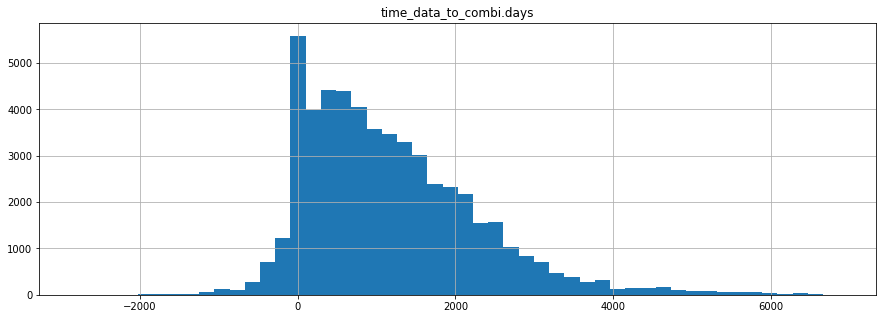

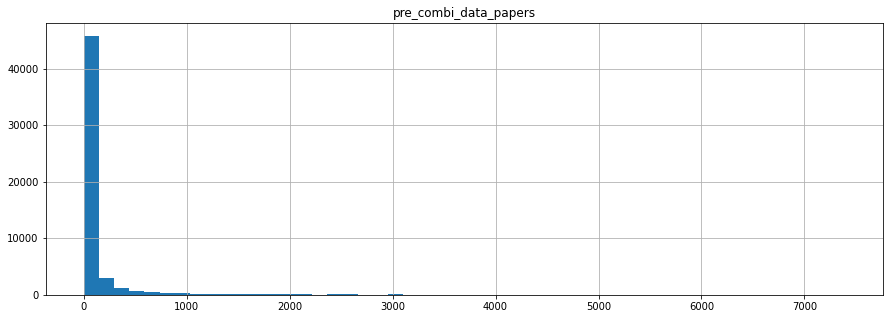

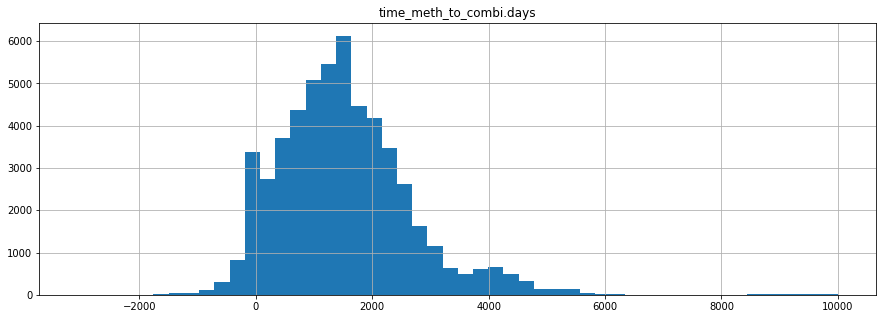

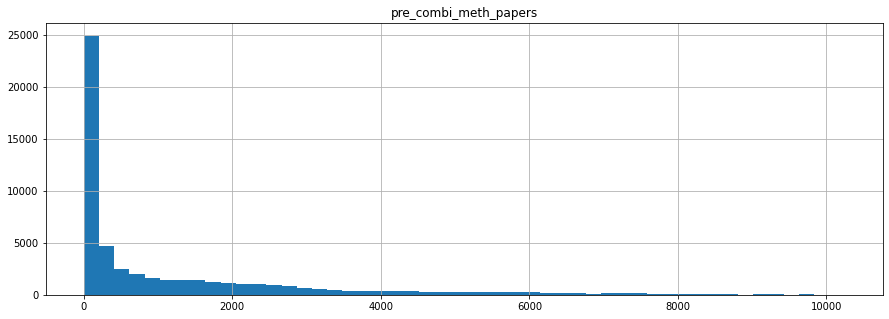

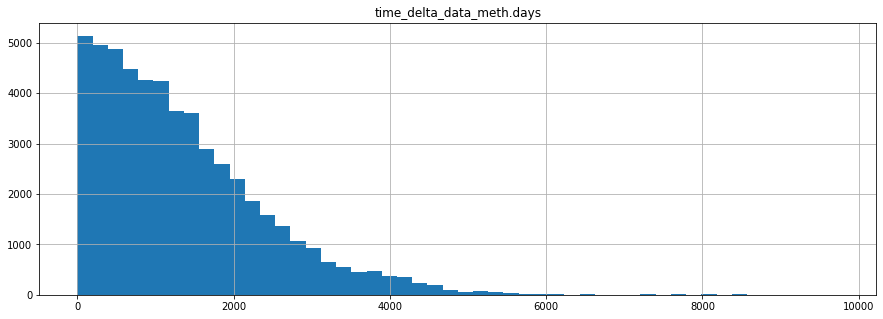

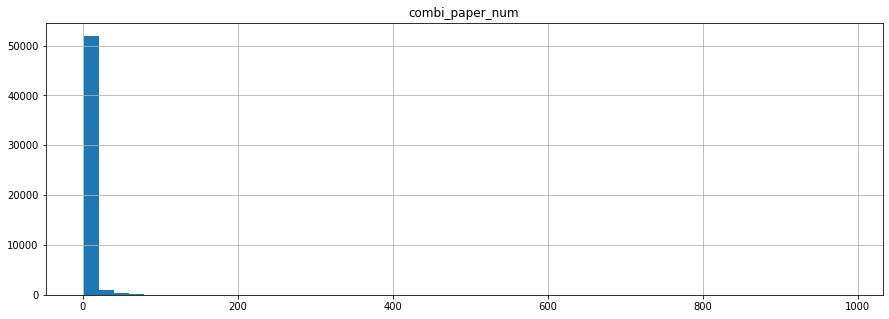

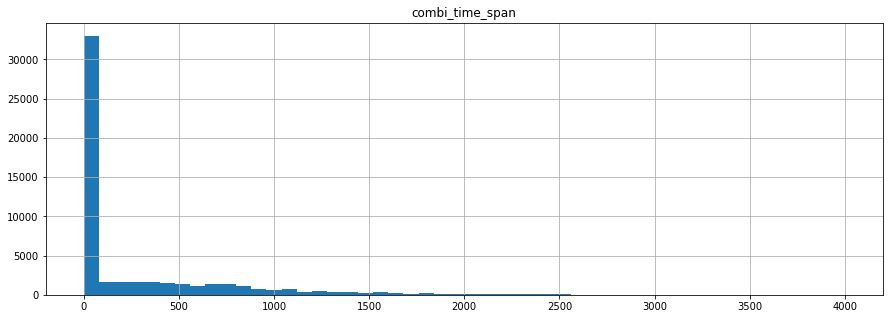

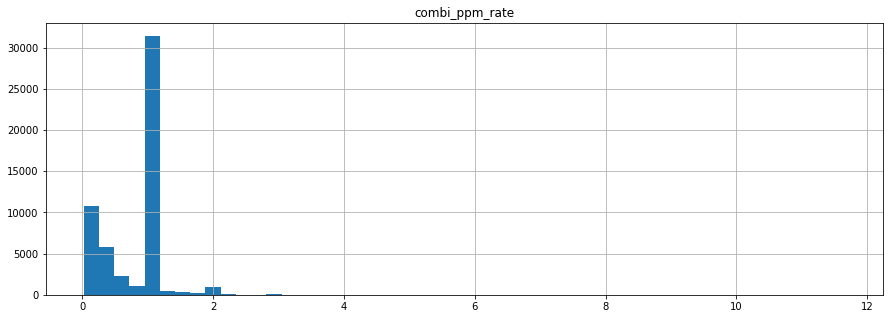

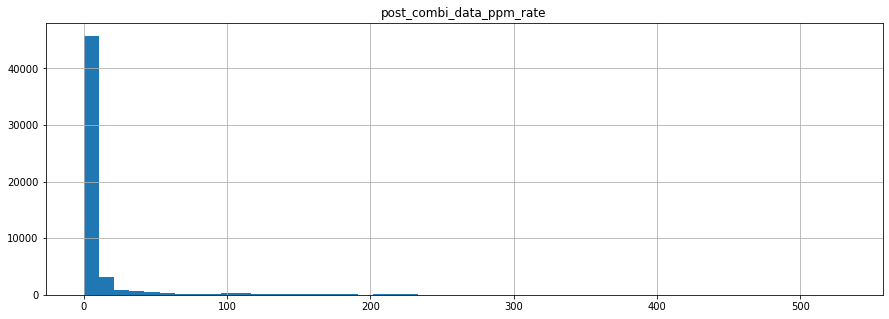

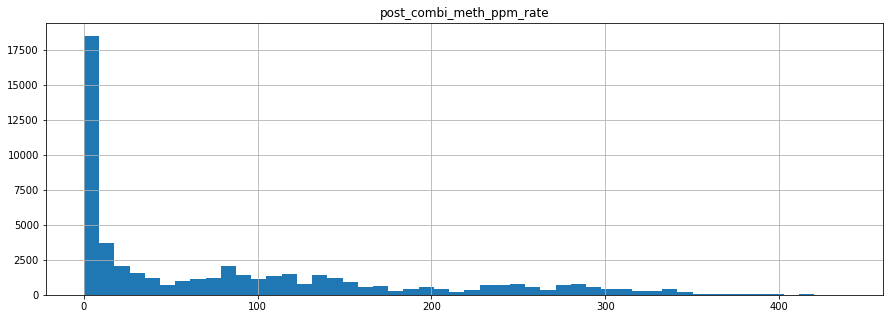

In [1069]:
for col_name in df_combi_metrics.columns[1:]:
    # df_combi_metrics[col_name].plot(kind='hist', log=True, bins=50, figsize=(15,5))
    df_combi_metrics[col_name].hist(bins=50, figsize=(15,5))
    _ = plt.title(col_name)
    plt.show()

In [1077]:
df_combi_metrics.sort_values(
    by=[
        'time_data_to_combi.days',
        'time_meth_to_combi.days',
        'pre_combi_meth_papers'
    ],
    ascending=[
        False,
        False,
        False
    ]
).head(50)

,pair_key,time_data_to_combi.days,pre_combi_data_papers,time_meth_to_combi.days,pre_combi_meth_papers,time_delta_data_meth.days,combi_paper_num,combi_time_span,combi_ppm_rate,post_combi_data_ppm_rate,post_combi_meth_ppm_rate
0,20 Newsgroups + Graph Convolutional Network,6853,9,1706,378,5147,1,0,1.000000,1.396193,16.781481
0,CoNLL-2003 + Packed Levitated Markers,6668,329,0,0,6668,1,0,1.000000,15.505642,0.000000
0,CoNLL-2003 + Auxiliary Classifier,6565,301,3105,237,3460,1,0,1.000000,10.535885,5.321154
0,CoNLL-2003 + Sequence to Sequence,6565,301,2457,367,4108,1,0,1.000000,10.535885,10.145667
0,CoNLL-2003 + Early exiting using confidence me...,6560,297,1360,14,5200,1,0,1.000000,11.294233,3.000000
0,CoNLL-2003 + DistilBERT,6560,297,604,35,5956,1,0,1.000000,11.294233,4.133420
0,PROTEINS + Mixup,6528,149,1315,153,5213,1,0,1.000000,5.570170,11.721081
0,CoNLL-2003 + Batch Normalization,6520,287,2258,2848,4262,1,0,1.000000,10.448522,86.068263
0,CoNLL-2003 + Residual Block,6520,287,2187,1463,4333,1,0,1.000000,10.448522,38.792255
0,CoNLL-2003 + Segregated Attention Network,6520,287,0,0,6520,1,0,1.000000,10.448522,0.000000
